# RNA Energy Barriers: Complexity Analysis

This notebook provides a formal analysis of the computational complexity of the algorithms implemented for finding RNA energy barriers.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import RNA

from src.rna_structure import RNAStructure
from src.path_finding import find_direct_path
from src.energy import base_pair_minimization_energy, turner_energy
import src.evolution as ev

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Theoretical Complexity Analysis

Let's analyze the theoretical time and space complexity of our algorithms for finding RNA energy barriers. We'll denote the length of the RNA sequence as `n`.

### 1.1 Direct Path Heuristic

The direct path heuristic has the following steps:
1. Determine which base pairs are in the start structure but not in the end structure (pairs to remove)
2. Determine which base pairs are in the end structure but not in the start structure (pairs to add)
3. Remove pairs that are in start but not in end, then add pairs that are in end but not in start

#### Time Complexity

- Finding the symmetric difference between two sets of base pairs: O(m), where m is the maximum number of base pairs in either structure
- Since a valid RNA structure can have at most O(n) base pairs (where n is the sequence length), the upper bound for m is O(n)
- Removing or adding a base pair takes O(1) time per operation
- For each structure in the path, we evaluate its energy, which takes O(n³) time using the Turner energy model
- The length of the path is at most 2m, since we can remove at most m pairs and add at most m pairs

Therefore, the overall time complexity for the direct path heuristic is O(n × n³) = O(n⁴) in the worst case.

#### Space Complexity

- We store the path, which contains at most 2m+1 structures
- Each structure requires O(n) space to store

Therefore, the space complexity is O(n²) in the worst case.

### 1.2 Indirect Path Heuristic

The indirect path heuristic explores a broader set of moves beyond the direct path. For each step:
1. Generate all possible single base pair additions or removals
2. Calculate energies for all possible moves
3. Select the next move based on probabilities

#### Time Complexity

- Generating all possible moves: O(n²), since there are O(n²) possible base pairs
- For each potential move, we need to check if it's valid (non-crossing), which takes O(n) time
- Calculating energy for each potential structure: O(n³) per structure
- In the worst case, the path length could be exponential in n

Therefore, the time complexity for the indirect path heuristic is O(n² × n × n³) = O(n⁶) per step, and the overall complexity depends on the number of steps needed to reach the target structure, which could be exponential in the worst case.

#### Space Complexity

- In each step, we store O(n²) potential next structures
- We also store the path, which could grow to exponential length in the worst case

Therefore, the space complexity is O(n² + path_length), where path_length could be exponential in the worst case.

### 1.3 Evolutionary Approach

The evolutionary approach maintains a population of candidate structures and evolves them toward the target structure:

#### Time Complexity

- Population size: N (constant)
- For each individual in the population, we generate a new candidate via a one-base move: O(N × n⁶) per generation
- Number of generations: potentially exponential in n in the worst case

Therefore, the time complexity is O(N × n⁶ × generations), where generations could be exponential in the worst case, but is bounded by max_steps in our implementation.

#### Space Complexity

- We store a population of N structures, each requiring O(n) space
- For each individual, we also store its path, which could grow to O(max_steps) length

Therefore, the space complexity is O(N × n × max_steps).

## 2. Why is the RNA Energy Barrier Problem NP-complete?

The RNA energy barrier problem is NP-complete because:

1. **Exponential Search Space**: The number of possible secondary structures for an RNA sequence grows exponentially with the sequence length.

2. **Local Minima**: The energy landscape contains many local minima, making it difficult to find the global minimum energy path.

3. **Barrier Height Verification**: Verifying that a given path has a barrier height less than some constant k can be done in polynomial time, making the problem NP.

4. **Reduction from Known NP-complete Problems**: The problem can be reduced from other NP-complete problems, such as the partition problem or the minimum feedback vertex set problem.

The barrier height computation has been shown to be NP-complete even under simple energy models, such as the base pair energy model where each base pair contributes -1 to the energy.

## 3. Empirical Complexity Analysis

Let's measure the actual running time of our algorithms on RNA sequences of varying lengths to empirically validate our complexity analysis.

In [3]:
def generate_random_rna(length):
    """Generate a random RNA sequence of given length"""
    bases = ['A', 'U', 'G', 'C']
    return ''.join(np.random.choice(bases) for _ in range(length))

In [4]:
def measure_direct_path_time(seq_length, num_trials=3):
    """Measure the time taken by the direct path algorithm for a given sequence length"""
    times = []
    
    for _ in range(num_trials):
        # Generate a random RNA sequence
        seq = generate_random_rna(seq_length)
        
        # Generate start and end structures
        fc = RNA.fold_compound(seq)
        start_struct, _ = fc.mfe()
        end_struct = '.' * seq_length  # Completely unpaired structure
        
        # Create RNA structure objects
        start = RNAStructure(seq, structure=start_struct)
        end = RNAStructure(seq, structure=end_struct)
        
        # Measure time for direct path finding
        start_time = time.time()
        path = find_direct_path(start, end)
        end_time = time.time()
        
        times.append(end_time - start_time)
    
    return np.mean(times)

In [6]:
def measure_evolutionary_time(seq_length, num_trials=3, N=10, max_steps=100):
    """Measure the time taken by the evolutionary algorithm for a given sequence length"""
    times = []
    
    for _ in range(num_trials):
        # Generate a random RNA sequence
        seq = generate_random_rna(seq_length)
        
        # Generate start and end structures
        fc = RNA.fold_compound(seq)
        start_struct, _ = fc.mfe()
        end_struct = '.' * seq_length  # Completely unpaired structure
        
        # Measure time for evolutionary algorithm
        start_time = time.time()
        best, steps = ev.best_folding(seq, start_struct, end_struct, N=N, max_steps=max_steps)
        end_time = time.time()
        
        times.append(end_time - start_time)
    
    return np.mean(times)

In [9]:
# Measure running times for different sequence lengths
seq_lengths = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
direct_times = []
evolutionary_times = []

for length in seq_lengths:
    print(f"Measuring for sequence length {length}...")
    direct_time = measure_direct_path_time(length)
    evolutionary_time = measure_evolutionary_time(length)
    
    direct_times.append(direct_time)
    evolutionary_times.append(evolutionary_time)
    
    print(f"  Direct path time: {direct_time:.4f} seconds")
    print(f"  Evolutionary time: {evolutionary_time:.4f} seconds")

Measuring for sequence length 10...
  Direct path time: 0.0000 seconds
  Evolutionary time: 0.0017 seconds
Measuring for sequence length 20...

Generation 10:
{'structure': '....................', 'distance': 0, 'highest_energy': 2.800000011920929, 'path': ['((((......))))......', '(((........)))......', '.((........)).......', '.(((......))).......', '..((......))........', '..(........)........', '....................'], 'energy_profile': [0, 1.0, 2.5, 1.2000000476837158, 1.2000000476837158, 2.5, 0.0]}

Generation 10:
{'structure': '......(((....)))....', 'distance': 6, 'highest_energy': 3.899999976158142, 'path': ['.((((.(((....)))))))', '..(((.(((....)))))).', '.((((.(((....)))))))', '..(((.(((....)))))).', '...((.(((....)))))..', '....(.(((....))))...', '......(((....)))....'], 'energy_profile': [0, -2.5999999046325684, -4.5, -2.5999999046325684, -2.0, -0.6000000238418579, -1.899999976158142]}

Generation 20:
{'structure': '......((......))....', 'distance': 4, 'highest_energy': 6

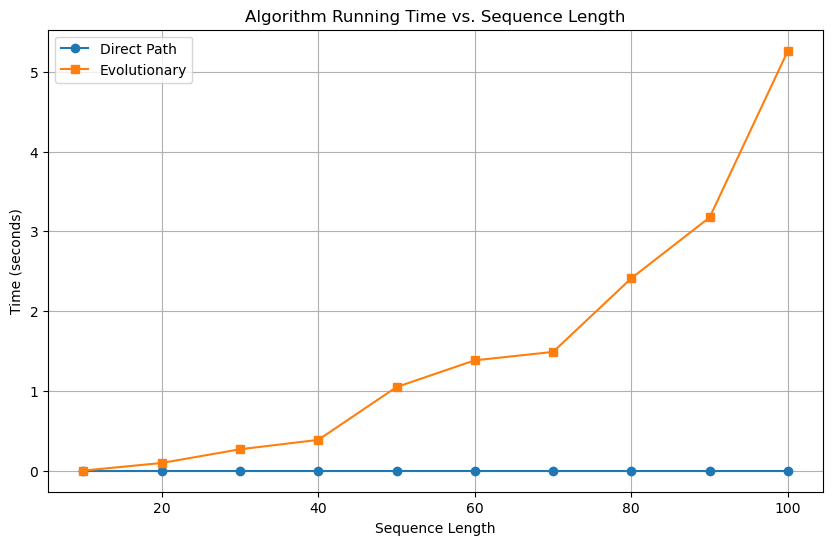

In [10]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(seq_lengths, direct_times, 'o-', label='Direct Path')
plt.plot(seq_lengths, evolutionary_times, 's-', label='Evolutionary')
plt.xlabel('Sequence Length')
plt.ylabel('Time (seconds)')
plt.title('Algorithm Running Time vs. Sequence Length')
plt.legend()
plt.grid(True)
plt.show()

## 4. How Our Heuristics Approximate Solutions

Given that the RNA energy barrier problem is NP-complete, our heuristics provide practical approximations to the optimal solution. Here's how they work:

### 4.1 Direct Path Heuristic

The direct path heuristic makes a significant simplification by only considering paths that directly transform the start structure into the end structure, without any "detours." This drastically reduces the search space from exponential to polynomial size.

**Approximation Quality**:
- In cases where the optimal path is indeed direct, this heuristic finds the exact solution.
- However, when the optimal path requires intermediate structures that are not steps toward the end structure, the direct path can yield much higher energy barriers.
- The quality of approximation depends on the "smoothness" of the energy landscape between the start and end structures.

### 4.2 Evolutionary Approach

The evolutionary approach uses a population-based search that allows for exploration of a broader range of paths, including non-direct ones.

**Approximation Quality**:
- By maintaining a diverse population of candidate solutions, it can potentially escape local minima.
- The selection pressure guides the search toward lower energy barriers.
- The quality of approximation depends on population size, number of generations, and selection parameters.
- While still not guaranteed to find the global optimum, it typically finds better solutions than the direct path heuristic, especially in complex energy landscapes.

## 5. Summary of Complexity Analysis

- **Direct Path Heuristic**: O(n⁴) time complexity, O(n²) space complexity
- **Indirect Path Heuristic**: O(n⁶) time complexity per step, potentially exponential overall in the worst case
- **Evolutionary Approach**: O(N × n⁶ × generations) time complexity, where generations is bounded by max_steps

The direct path heuristic provides a polynomial-time approximation but may miss optimal solutions that require non-direct paths.

The indirect and evolutionary approaches can find better solutions, particularly in complex energy landscapes, but at the cost of higher computational complexity.

In practice, the choice of algorithm depends on the tradeoff between solution quality and computational resources available.